# Imports

In [16]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchaudio

import IPython
import random
import os

import pickle
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style("darkgrid")
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Setup/Config

In [17]:
class Config():
    # Setup
    data_path = r"C:/Users/JK/Desktop/Onedrive/Programming/Data/LJSpeech-1.1"
    spectrogram_path = r"C:\Users\JK\Desktop\temp_local_emb"
    sample_rate = 22050
    new_sample_rate = 4000
    max_time = 5.0
    max_len = int(max_time * new_sample_rate)
    do_preprocess = False
    make_spectrograms = False # This takes a fucking eternity and a lot of space
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Model and dataloader config
    batch_size = 2
    model_bins = 128
    model_channels = 256
    model_dilation_depth = 10
    
    # Training
    epochs = 10
    learning_rate = 1e-4
    
C = Config()

# Helpers

In [18]:
mu = torchaudio.transforms.MuLawEncoding(quantization_channels=C.model_bins)
mu_decoder = torchaudio.transforms.MuLawDecoding(quantization_channels=C.model_bins)

def load_sound(wave_id):
    path = C.data_path + "/wavs/" + wave_id + ".wav"
    assert os.path.exists(path), "bad path/id given"
    return torchaudio.load(path)[0][0]

def load_spectrogram(wave_id):
    load_path = C.spectrogram_path + "/" + str(wave_id) + ".pickle"
    assert os.path.exists(load_path), "bad path/id given"
    with open(load_path, 'rb') as handle:
        mel_spectrogram = pickle.load(handle)
    return mel_spectrogram[0].float().to(C.device)
    
def one_hot(x_mu):
    as_int64 = x_mu.long()
    one_hotted = F.one_hot(as_int64, num_classes=C.model_bins)
    correct_dims = one_hotted.transpose(1,2)
    as_float32 = correct_dims.float()
    return as_float32

def mu_and_1hot(x):
    x = mu(x)
    x = one_hot(x)
    return x

# Preprocess
For whatever reason windows has decided to complain about some wierd decoding error after the last update. I've fixed it by loading the csv file into colab and deleting the non-normalized transcript hence ```metadata_clean.csv```.

In [19]:
if C.do_preprocess:
    data = pd.read_csv(C.data_path + "/metadata_clean.csv")
    times = []

    for wave_id in data["waveform_id"]:
        waveform = load_sound(wave_id)
        sound_duration = waveform[0].shape[0]/C.sample_rate
        times.append(sound_duration)

    data["time"] = times
    data.to_csv(C.data_path + "/metadata_clean.csv", index=False)
else:
    data = pd.read_csv(C.data_path + "/metadata_clean.csv")
    display(data.head(3))
    
# Data subset according to the maximum time length allowed
subset_indices = data["time"] < C.max_time
data = data[subset_indices].reset_index(drop=True)
print(f"Number of samples below {C.max_time} seconds: {len(data)}\
        \nCombined time: {round(sum(data.time)/60**2,3)} [hours]")
display(data.head((3)))

# Remove rows with missing transripts
nan_indices = data[data["transcript"].isnull()].index
data = data.drop(index=nan_indices).reset_index(drop=True)
assert data.isnull().sum().sum() == 0, "found nans"

,waveform_id,transcript,time
0,LJ001-0001,"Printing, in the only sense with which we are ...",9.655011
1,LJ001-0002,in being comparatively modern.,1.899546
2,LJ001-0003,For although the Chinese took impressions from...,9.666621


Number of samples below 5.0 seconds: 3313        
Combined time: 3.308 [hours]


,waveform_id,transcript,time
0,LJ001-0002,in being comparatively modern.,1.899546
1,LJ001-0008,has never been surpassed.,1.783447
2,LJ001-0011,it is of the first importance that the letter ...,4.511791


In [24]:
data.min()

waveform_id                                           LJ001-0002
transcript     (four) evidence establishing the ownership of ...
time                                                     1.11007
dtype: object

# Transforms
Find a reasonable resample rate. NOTE: 4000 seems too low, but not sure if it's alright, but I'll stick to 6000 for know, just to be sure.

At sample rate: 22050


At sample rate: 4000


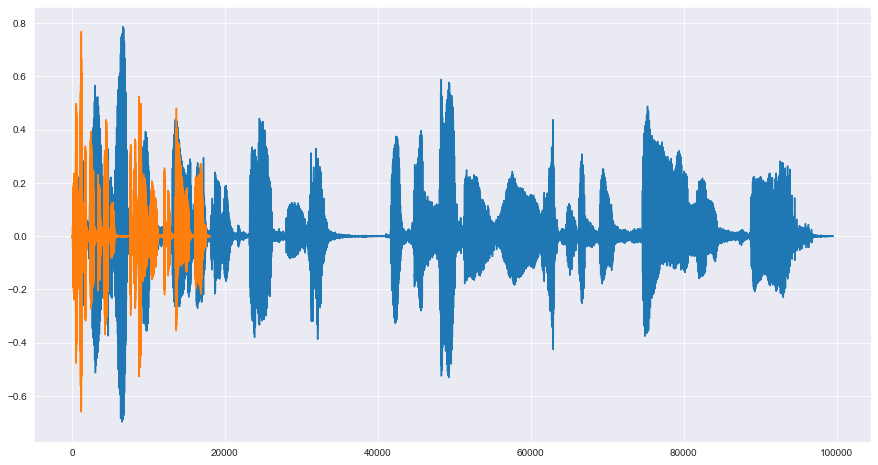

In [20]:
sample = load_sound(data["waveform_id"][2])

transforms = torchaudio.transforms.Resample(C.sample_rate, C.new_sample_rate)
resampled = transforms(sample)

plt.figure(figsize=(15,8))
plt.plot(sample)
plt.plot([i for i in range(len(resampled))], resampled)

print(f"At sample rate: {C.sample_rate}")
display(IPython.display.Audio(sample.numpy(), rate=C.sample_rate))

print(f"At sample rate: {C.new_sample_rate}")
display(IPython.display.Audio(resampled.numpy(), rate=C.new_sample_rate))
torchaudio.save(f'4000.wav', resampled.unsqueeze(0), sample_rate=4000)

# Fix alignment
As i see it there's two options for alignment: zero pad or cutting slices in fixed intervals. Cutting seems most efficient, but is probably also the most error prone. Whereas zero padding is incrediably inefficient, but seems way more safe. I think the best way to do this is simply to find the longest audio_file and zero pad all the other audio files accordingly

In [21]:
# Calculating max_len precisely
#C.max_len = max([len(transforms(load_sound(wave_id))) for wave_id in data["waveform_id"]])

# Tacotron
I've noticed that Tacotron is super random if the text it receives has no end punctuation i.e. ".", "?" or "!". It still works, but the embeddings are not at all deterministic, you get different spectrograms each time you run the code. Even with end punctuation there's still some randomness to the spectrograms, but they are fairly consistent. Maybe this is only a problem with short sentences? TODO: check end punctuation is present in all transcripts and add "." if not

Using cache found in C:\Users\JK/.cache\torch\hub\nvidia_DeepLearningExamples_torchhub


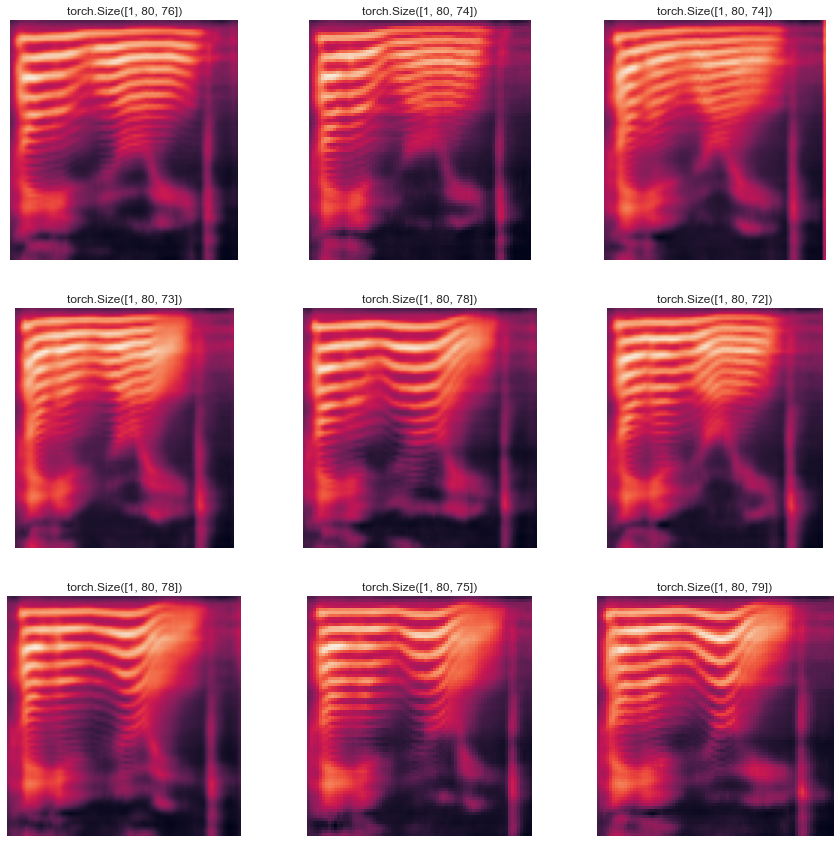

In [22]:
tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2')
tacotron2 = tacotron2.to(C.device)
tacotron2.eval()

def get_tacotron_spectrogram(transcript):
    sequence = np.array(tacotron2.text_to_sequence(transcript, ['english_cleaners']))[None, :]
    sequence = torch.from_numpy(sequence).to(device=C.device, dtype=torch.int64)
    _, mel, _, _ = tacotron2.infer(sequence)
    return mel.detach()

text = "Hello world."

_, axes = plt.subplots(3,3, figsize=(15,15))
for y in range(3):
    for x in range(3):
        mel = get_tacotron_spectrogram(text)
        
        axes[x][y].imshow(mel[0].cpu().detach().numpy())
        axes[x][y].axis("off");
        axes[x][y].set_title(str(mel.shape))

# How to deal with local embeddings
The obvious thing to do is to simple upscale uniformly, but what about the padding? Seems like the only real solution is to interpolate the mel-spec on the non-padded waveform and then pad the local embeddings aswell. This somehow feels wrong though..

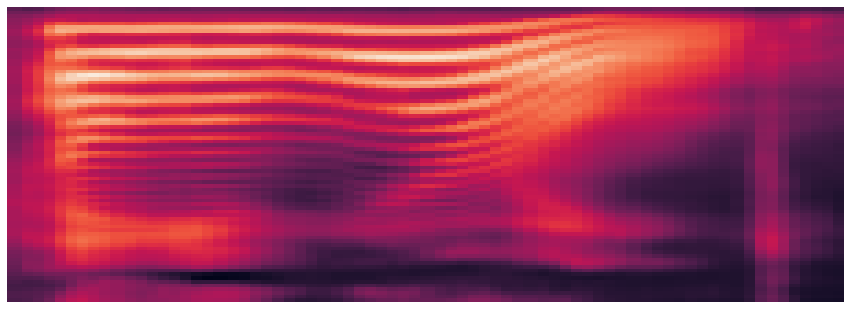

In [8]:
waveform = load_sound(data["waveform_id"][0])
resampled_waveform = transforms(waveform)
transcript = "Hello world."#data["transcript"][0]

sequence = np.array(tacotron2.text_to_sequence(transcript, ['english_cleaners']))[None, :]
sequence = torch.from_numpy(sequence).to(device=C.device, dtype=torch.int64)
_, mel, _, _ = tacotron2.infer(sequence)

# The /50 is just for plotting in reality the spectrogram would be way more pixelated
upscaled_mel = F.interpolate(mel, size=len(resampled_waveform)//50, 
                         mode='nearest')[0].cpu().detach().numpy()
plt.figure(figsize=(15,10))
plt.imshow(upscaled_mel)
plt.axis("off");

### Padding the upscaled embeddings

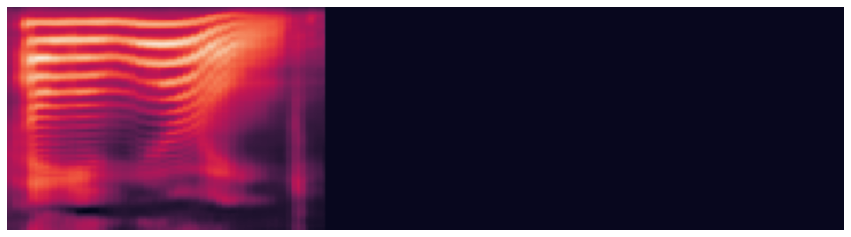

In [9]:
upscaled_mel = F.interpolate(mel, size=len(resampled_waveform), mode='nearest')

pad_amount = C.max_len - len(resampled_waveform)
padded_waveform = F.pad(resampled_waveform, (0, pad_amount), "constant", 0)
padding = torch.ones((1, 80, pad_amount)).to(C.device) * (-10) # -10 = black
padded_mel = torch.cat( (upscaled_mel, padding), dim=2)

# The interpolation is just for plotting.
plt.figure(figsize=(15,10)) 
plt.imshow(F.interpolate(padded_mel, size=300, mode='nearest').detach().cpu().numpy()[0])
plt.axis("off");

## Making and saving spectrograms-embeddings
Making the mel-spectrograms from Tacotron on the fly increased the training time by x5, so it seems worth the trouble. They do however take up a shit ton of space so I've saved them as float16 (.half), cannot see how that should be an issue though

In [10]:
if C.make_spectrograms:
    for index, row in data.iterrows():
        wave_id, transcript = row["waveform_id"], row["transcript"]
        waveform = load_sound(wave_id)
        resampled_waveform = transforms(waveform)
        pad_amount = C.max_len - len(resampled_waveform)
        padded_waveform = F.pad(resampled_waveform, (0, pad_amount), "constant", 0)
        
        mel = get_tacotron_spectrogram(transcript)
        upscaled_mel = F.interpolate(mel, size=len(resampled_waveform), mode='nearest')
        mel_padding = torch.ones((1, 80, pad_amount)).to(C.device) * (-10) # -10 ~= black i.e. no sound
        padded_mel = torch.cat( (upscaled_mel, mel_padding), dim=2)

        save_path = C.spectrogram_path + "/" + str(wave_id) + ".pickle"
        with open(save_path, 'wb') as handle:
            pickle.dump(padded_mel.half(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        if index%100 == 0:
            print(index)


# Dataset, DataLoader

In [11]:
class LJ_Dataset:
    def __init__(self, data, path, transforms, max_len):
        self.data = data
        self.transforms = transforms
        self.max_len = max_len

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        # Simple load
        wave_id = self.data["waveform_id"][i]
        waveform = load_sound(wave_id)
        transcript = self.data["transcript"][i]
        
        # Reduce amount of samples (resample) and pad such 
        # that all the waveforms have the same length
        resampled_waveform = self.transforms(waveform)
        pad_amount = self.max_len - len(resampled_waveform)
        padded_waveform = F.pad(resampled_waveform, (0, pad_amount), "constant", 0)
        assert len(padded_waveform) == self.max_len, "Well, this should not have happend"
        
        # Local embedding. Tacotron mel spectrogram is interpolated to match the non-padded
        # waveform and any zero padding in ´padded_waveform´ is matched in ´padded_mel´
        padded_mel = load_spectrogram(wave_id)
        
        assert padded_mel.shape[1] == self.max_len, "Well, this should not have happend"
    
        return padded_waveform, transcript, padded_mel


In [12]:
dataset = LJ_Dataset(data, C.data_path, transforms, C.max_len)
train_dl = torch.utils.data.DataLoader(dataset,batch_size=C.batch_size, shuffle=True)

## Sanity check

The fatal news was not always received in the same way.  |  length seconds: 5.0


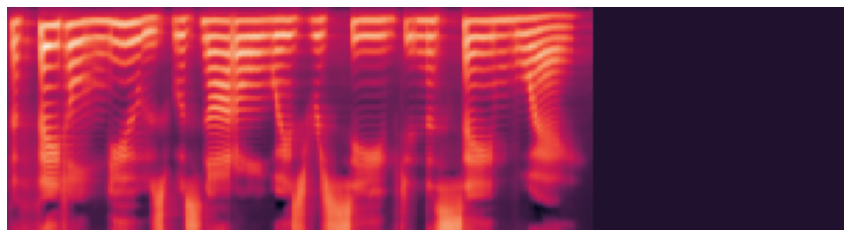

In [13]:
wavs, texts, local_embs = next(iter(train_dl))

print(texts[0], f" |  length seconds: {round(wavs[0].shape[0]/C.new_sample_rate,3) }")
display(IPython.display.Audio(wavs[0].numpy(), rate=C.new_sample_rate))

# The interpolation is just for plotting.
plt.figure(figsize=(15,10)) 
plt.imshow(F.interpolate(local_embs, size=300, mode='nearest').detach().cpu().numpy()[0])
plt.axis("off")

del wavs, texts, local_embs

# Model
Stripped away ereything I possible could. There's no global conditioning and local conditioning is literally just getting added to the filter and gate variables in the ```ResidualLayer```. This means there's no actual learned upsamling, just a single column of the interpolated Tacotron mel-spectrogram (1x80 vector embedding) which get passed through conv1x1 (ones in the wavenet model and ones in the each layers)

In [14]:
from wavenet_minimal import WaveNet
model = WaveNet(C.model_bins, C.model_channels, C.model_dilation_depth)
model.to(C.device);

# Sanity check
wavs, texts, local_embs = next(iter(train_dl))
wavs, local_embs = wavs.to(C.device), local_embs.to(C.device)
print(model(mu_and_1hot(wavs), local_embs).shape)
del wavs, texts, local_embs

torch.Size([2, 128, 28977])


# Optimizer, loss, schedular

In [15]:
optim = torch.optim.Adam(model.parameters(), lr=C.learning_rate)
loss_func = torch.nn.CrossEntropyLoss()
avg_losses = []

# Training

In [16]:
# Training loop
for epoch in range(C.epochs):
    progress_bar = tqdm(train_dl, total=len(train_dl), leave=False)
    losses = []
    for i, (waveforms, _, local_embeddings) in enumerate(progress_bar):
        model.train()
        waveforms.to(C.device)
        local_embeddings.to(C.device)
        
        # Correctly formats data for Wavenet and its loss
        y_true = mu(waveforms).to(C.device)
        x = one_hot(y_true)
        
        # Model predictions
        y_preds = model(x, local_embeddings)   

        # Calculates loss. The whole indexation show is just to align predictions with the true values.
        loss = loss_func(y_preds[:, :, :-1], y_true[:, -y_preds.size(2)+1:])
        
        # Updates
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
        progress_bar.set_postfix({"train_loss": loss.detach().cpu().item()})
    
    avg_losses.append(np.mean(losses))
    print(f"avg_train: {np.mean(avg_losses)}")

plt.figure(figsize=(12,8))
plt.plot(avg_losses, label="Avg. Cross entropy loss - train")
plt.legend()

  0%|          | 0/1655 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 566.00 MiB (GPU 0; 6.00 GiB total capacity; 3.24 GiB already allocated; 278.39 MiB free; 3.85 GiB reserved in total by PyTorch)

# Generate

In [ ]:
def get_interpolated_mel(text):
    mel = get_tacotron_spectrogram('in being comparatively modern.')
    interpolated_mel = F.interpolate(mel, size=mel.shape[2]*65, mode='nearest')
    return interpolated_mel[0]
    
def generate(seed, text, model):
    
    model.eval()
    receptive_field = sum(model.dilations)
    local_emb = get_interpolated_mel(text)
    temp = seed.tolist()
    
    for n in tqdm(range(local_emb.shape[1] - receptive_field), leave=False):
        input = torch.tensor(temp[ -(receptive_field+1):])
        input = input.long().to(C.device)
        input = one_hot(input.unsqueeze(0))
        
        single_embedding = local_emb[:, n + receptive_field].view(1,80,1)
        predictions = model(input, single_embedding)
        predictions = torch.softmax(predictions, dim=1)
        max_index = torch.multinomial(predictions[0, :, 0], 1).squeeze()
        temp.append(max_index.item())
    
    return temp

In [ ]:
sample = transforms(load_sound("LJ001-0002"))
seed = seed[:sum(model.dilations)+1]
text = dataset[0][1]
gen = generate(seed, text, model)

mu_decoded_gen = mu_decoder(torch.tensor(gen))
gen_export = mu_decoded_gen.view(1,-1).float()
torchaudio.save(f'tester.wav', gen_export, sample_rate=C.new_sample_rate)
display(IPython.display.Audio(f"tester.wav", rate=C.new_sample_rate))
plt.plot(gen_export[0])
plt.title(text)
plt.show()

In [ ]:
plt.plot(sample)
plt.title(text)
plt.show()

# Save model

In [ ]:
# from time import gmtime, strftime
# name = "10_epoch_"
# torch.save(model.state_dict(), f"model_{name}.pth")